In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc

import sys
sys.path.append('../')

TEXT_COLOR = 'w'
FACECOLOR = '#373d4b'
mpl.rcParams['axes.facecolor'] = '#373d4b'
mpl.rcParams['text.color'] = TEXT_COLOR
mpl.rcParams['axes.labelcolor'] = TEXT_COLOR
mpl.rcParams['xtick.color'] = TEXT_COLOR
mpl.rcParams['ytick.color'] = TEXT_COLOR

import albumentations
from melanoma.data.dataset import MelanomaDataset
from melanoma.data.augmentation import MelanomaAugmentor
from melanoma.utils import data_utils
from melanoma.utils.data_utils import load_data

In [3]:
image_map={
    '2020':'../data/ISIC_2020/224x224_jpg_100_4/train/',
    '2019': '../data/ISIC_2019/224x224_jpg_100_4/train/'
}
df_train = load_data('../data/train.csv', 
                     duplicate_path='../data/sus/2020_Challenge_duplicates.csv', 
                     external_filepaths=['../data/external_data/isic_2019.csv'],
                     image_map=image_map
                    )
root = '../data/ISIC_2020/224x224_jpg_100_4/'
df_train['image_dir'] = root
ds = MelanomaDataset(df_train, 'train')
dl = DataLoader(ds, batch_size=16)

img_stats = data_utils.load_img_stats('../data/cv_folds/cv_folds_20200802_0048/224x224_jpg_100_4/', 0)
mean = np.array(img_stats['source']['ISIC_2020']['mean'], np.float32)
std = np.array(img_stats['source']['ISIC_2020']['std'], np.float32)

Adding external data from ../data/external_data/isic_2019.csv
Loading img stats for fold 0 from ../data/cv_folds/cv_folds_20200802_0048/224x224_jpg_100_4/fold_0/img_stats.json


In [6]:
import os
import sys
import time
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
try:
    from apex import amp
except:
    pass

from sklearn.metrics import roc_auc_score, log_loss
from melanoma.utils.generic_utils import Logger
from melanoma.utils.model_utils import load_model
from melanoma.utils import data_utils, train_utils
from melanoma.evaluation.metrics import compute_auc


class Trainer:
    """Melanoma trainer."""

    def __init__(self,
                 model,
                 optim=None,
                 criterion=None,
                 task='clf',
                 scheduler=None,
                 metrics=None,
                 postprocessor=None,
                 max_norm=None,
                 ckpt_dir=None,
                 reg_params=None,
                 monitor=None,
                 fp_16=False,
                 rank=0,
                 **kwargs):
        self.model = model
        self.optim = optim
        self.criterion = criterion
        self.scheduler = scheduler
        self.postprocessor = postprocessor
        self.ckpt_dir = ckpt_dir
        self._metrics = metrics
        self._task = task
        self.reg_params = reg_params
        self._monitor = monitor
        self._rank = rank
        self._max_norm = max_norm
        self._fp_16 = fp_16
        self._is_cuda = next(self.model.parameters()).is_cuda

        self._global_step = None
        self._best_loss = None
        self._best_score = None
        self._best_loss_step = None
        self._best_score_step = None
        self._new_best = False
        self._history = None
        self.logger = None
        if self.reg_params is None:
            self._apply_mixup = None
            self._apply_cutmix = None
        else:
            self._apply_mixup = 'mixup' in self.reg_params
            self._apply_cutmix = 'cutmix' in self.reg_params

        if self.logger is None:
            self.logger = sys.stdout
        if self._metrics is None:
            self._metrics = ['roc_auc_score']

        self._reset()

    @property
    def best_step(self):
        return self._best_score_step

    @property
    def history(self):
        return self._history

    @property
    def is_cuda(self):
        return self._is_cuda

    @property
    def device(self):
        return next(self.model.parameters()).device

    @device.setter
    def device(self, device):
        self._is_cuda = getattr(device, 'type', device) == 'cuda'

    @property
    def global_step(self):
        self._global_step

    @global_step.setter
    def global_step(self, step):
        self._global_step = step

    def _reset(self):
        if self.ckpt_dir is not None and not os.path.exists(self.ckpt_dir):
            os.makedirs(self.ckpt_dir, exist_ok=True)

        self._history = {
            'loss': [],
            'auc_score': [],
            'val_loss': [],
            'elapsed_time': [],
            'lr': [],
        }
        for name in self._metrics:
            self._history[f'val_{name}'] = []

        self._empty_cache()
        if self.ckpt_dir is not None:
            self.logger = Logger(os.path.join(self.ckpt_dir, 'train_history.log'))
        else:
            self.logger = sys.stdout

        self._global_step = 0
        self._best_loss = np.inf
        self._best_score = -np.inf
        self._best_loss_step = 0
        self._best_score_step = 0
        self._new_best = False

    def _empty_cache(self):
        if self.optim is not None:
            self.optim.zero_grad()
        torch.cuda.empty_cache()

    def _set_train_mode(self):
        self.model.train()

    def _set_eval_mode(self):
        self.model.eval()

    def _save_history(self):
        with open(os.path.join(self.ckpt_dir, 'history.json'), 'w') as f:
            json.dump(str(self._history), f)

    def _save_model(self):
        fname = f"ckpt_{self._global_step:04d}"
        fname += f"_{self._history['val_loss'][-1]:.6f}"
        fname += f"_{self._history['val_roc_auc_score'][-1]:.6f}.pt"
        filepath = os.path.join(self.ckpt_dir, fname)
        if self._fp_16:
            torch.save({
                'epoch': self._global_step,
                'state_dict': self.model.module.state_dict(),
                'best_loss': self._best_loss,
                'best_score': self._best_score
            }, filepath)
        elif isinstance(self.model, nn.DataParallel):
            torch.save(self.model.module.state_dict(), filepath)
        else:
            torch.save(self.model.state_dict(), filepath)

        if self.postprocessor is not None:
            filename = f'coef_{self._global_step:04d}.npy'
            np.save(os.path.join(self.ckpt_dir, filename), self.postprocessor.get_coef())

    def _load_model(self, step=None, filename=None, **kwargs):
        # this needs to be updated with the device
        self.model = load_model(self.ckpt_dir, step, filename, **kwargs)

    def fit(self, train_dl, steps=1, val_dl=None):
        start_time = time.time()
        self._empty_cache()
        if val_dl is not None:
            if isinstance(val_dl, list):
                y_val = torch.Tensor(val_dl[0].dataset.get_labels())
            else:
                y_val = torch.Tensor(val_dl.dataset.get_labels())
            if y_val.ndim == 1:
                y_val = y_val[..., None]
            if self.criterion.__class__.__name__ == 'BCELabelSmoothingLoss':
                y_val = y_val.long()
            else:
                y_val = y_val.float()

        for step in range(steps):
            self._global_step += 1
            self.train(train_dl)

            str_format = f"step {self._global_step} ({self._history['elapsed_time'][-1]}s) - loss : {self._history['loss'][-1]:.4f}"
            str_format += f" - auc_score : {self._history['auc_score'][-1]:.4f}"

            if self._rank == 0:
                if val_dl is not None:
                    y_pred = self.predict(val_dl)
                    val_loss = self.criterion(y_pred, y_val).item()
                    y_pred = y_pred.data.cpu()

                    if self.postprocessor is not None:
                        self.postprocessor.fit(y_pred, y_val.data.cpu().numpy().astype(int))

                    y_pred = self.postprocess(y_pred)
                    # val_score = compute_auc(y_val, y_pred)
                    str_format += f' - val_loss : {val_loss:.4f}'
                    self._history['val_loss'].append(val_loss)

                    val_scores = train_utils.compute_scores(y_val, y_pred, self._metrics)
                    for k, v in val_scores.items():
                        str_format += f' - val_{k} : {v:.4f}'
                        self._history[f'val_{k}'].append(v)

                    if self.scheduler is not None:
                        str_format += f" - lr : {self.optim.param_groups[0]['lr']:.8f}"

                    best_str = ''
                    if val_loss < self._best_loss:
                        best_str += f'`val_loss` improved from {self._best_loss:.6f} to {val_loss:.6f}'
                        self._best_loss = val_loss
                        self._best_loss_step = step + 1
                        self._new_best = True
                    if val_scores['roc_auc_score'] > self._best_score:
                        if len(best_str) > 0:
                            best_str += ' - '
                        best_str += f"`val_roc_auc_score` improved from {self._best_score:.6f} to {val_scores['roc_auc_score']:.6f}"
                        self._best_score = val_scores['roc_auc_score']
                        self._best_score_step = step + 1
                        self._new_best = True

                    if self._new_best and self.ckpt_dir is not None and self._rank == 0:
                        str_format = best_str + '\n' + str_format
                        self._save_model()

            # clear the current line of the console and log the steps results
            self.logger.write("\033[K")
            self.logger.write(str_format)
            self._new_best = False
            self._history['lr'].append(self.optim.param_groups[0]['lr'])

            if self.scheduler is not None:
                if self.scheduler.__class__.__name__ == 'OneCycleLR':
                    pass
                elif self._monitor is None:
                    self.scheduler.step()
                elif self._monitor == 'val_loss':
                    self.scheduler.step(val_loss)
                elif self._monitor == 'val_auc':
                    self.scheduler.step(val_score)
                else:
                    raise ValueError(f'Unrecognized `monitor` {self._monitor}')

        template_str = f'\n\nFinished training ({int(time.time()-start_time)}s)'
        if val_dl is not None:
            template_str += f' - best val_loss : {self._best_loss:.6f} (step {self._best_loss_step})'
            template_str += f' - best auc_score : {self._best_score:.6f} (step {self._best_score_step})'
        self.logger.write(template_str)

        if self.ckpt_dir is not None and self._rank == 0:
            self._save_history()
        self._set_eval_mode()

    def train_on_batch(self, x, y, y_b=None, lam=None):
        y_pred = self.model(x)
        if y_b is not None:
            loss = train_utils.regularized_criterion(self.criterion, y_pred, y, y_b, lam=lam)
        else:
            loss = self.criterion(y_pred, y)

        self.optim.zero_grad()
        if self._fp_16:
            with amp.scale_loss(loss, self.optim) as scaled_loss:
                scaled_loss.backward()
            if self._max_norm:
                nn.utils.clip_grad_norm_(amp.master_params(self.optim), self._max_norm)
        else:
            loss.backward()
            if self._max_norm:
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=self._max_norm)

        self.optim.step()
        torch.cuda.synchronize()

        if self.scheduler.__class__.__name__ == 'OneCycleLR':
            if self._fp_16 and amp._amp_state.loss_scalers[0]._unskipped != 0:
                self.scheduler.step()
            else:
                self.scheduler.step()

        y_pred = self.postprocess(y_pred.data.cpu().detach())
        return y_pred, loss.item()

    def train(self, train_dl):
        start_time = time.time()
        self._set_train_mode()
        num_batches = len(train_dl)
        pad_batch = int(np.log10(num_batches))
        train_score = None
        train_loss = None

        train_score_sum = 0
        train_loss_sum = 0
        n_dense = 0
        train_dl.dataset.df['target'].dtype
        targets = []
        for i, (x, y) in enumerate(train_dl):
            if y.ndim == 1:
                y = y[..., None]
            if self.criterion.__class__.__name__ == 'BCELabelSmoothingLoss':
                y = y.long()
            else:
                y = y.float()

            if self._is_cuda:
                x = x.cuda(self.device)
                y = y.cuda(self.device)

            if self._apply_mixup and np.random.uniform() > self.reg_params['mixup']['p']:
                x_mixed, y, y_mixed, lam = data_utils.mixup_data(
                    x, 
                    y, 
                    alpha=self.reg_params['mixup']['alpha'], 
                    use_cuda=self._is_cuda
                )
                y_pred, loss = self.train_on_batch(x_mixed, y, y_mixed=y_mixed, lam=lam)
            elif self._apply_cutmix and np.random.uniform() > self._reg_params['cutmix']['p']:
                x_cut, y, y_cut, lam = data_utils.cutmix_data(
                    x, 
                    y, 
                    beta=self.reg_params['mixup']['beta'], 
                    use_cuda=self._is_cuda
                )
                y_pred, loss = self.train_on_batch(x_cut, y, y_b=y_b, lam=lam)
            else:
                y_pred, loss = self.train_on_batch(x, y)
            
            # do we keep auc??? maybe set this to None when cutmix/up is applied
            score = compute_auc(y.data.cpu(), y_pred)
            if score is not None:
                train_score_sum += score
                n_dense += 1
            train_loss_sum += loss

            template_str = f'step {self._global_step} [{i+1:0{pad_batch+1}d}/{num_batches}'
            template_str += f' ({int(time.time()-start_time)}s)'
            template_str += f' - loss : {train_loss_sum/(i+1):.4f}'
            template_str += f' - auc_score : {train_score_sum/n_dense if n_dense > 0 else 0:.4f}\r'
            sys.stdout.write(template_str)
            sys.stdout.flush()
            targets.append(y.data.cpu().numpy().flatten())
        #print(targets[0])
        #print(np.array(list(map(sum, targets))))
        #props = [sum(targets[i])/len(targets[i]) for i in range(len(targets))]
        #print(f'mean   : {np.mean(props):.4f}')
        #print(f'std    : {np.std(props):.4f}')
        #print(f'median : {np.median(props):.4f}')
        if self._is_cuda:
            torch.cuda.empty_cache()

        self._history['loss'].append(train_loss_sum / num_batches)
        self._history['auc_score'].append(train_score_sum / num_batches)
        self._history['elapsed_time'].append(int(time.time()-start_time))

    def predict(self, dl):
        self._set_eval_mode()
        preds = []
        num_batches = len(dl)

        with torch.no_grad():
            for i, x in enumerate(dl):
                if isinstance(x, (list, tuple)) and len(x) == 2:
                    x = x[0]
                if self._is_cuda:
                    x = x.cuda(self.device)
                y_pred = self.predict_on_batch(x)
                preds.append(y_pred)

        if self._is_cuda:
            torch.cuda.empty_cache()

        return torch.cat(preds)

    def predict_on_batch(self, x):
        return self.model(x).data.cpu()

    def postprocess(self, y_pred, from_logit=True):
        if self._task == 'clf':
            return torch.sigmoid(y_pred).numpy()
            # return F.softmax(y_pred, dim=1).argmax(1).numpy()
        else:
            if self.postprocessor is not None:
                y_pred = self.postprocessor.predict(y_pred)
            return y_pred

    def load_model(self, step=None, filename=None, **kwargs):
        self._load_model(step=step, filename=filename, **kwargs)

    def save_model(self):
        if self.ckpt_dir is not None:
            self._save_model()

In [ ]:
r = np.random.rand(1)
if args.beta > 0 and r < args.cutmix_prob:
    # generate mixed sample
    lam = np.random.beta(args.beta, args.beta)
    rand_index = torch.randperm(input.size()[0]).cuda()
    target_a = target
    target_b = target[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
    input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
    # compute output
    output = model(input)
    loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)

(array([  2.,  19.,  40., 134., 184., 228., 198., 136.,  47.,  12.]),
 array([0.12250881, 0.19234306, 0.2621773 , 0.33201155, 0.4018458 ,
        0.47168005, 0.5415143 , 0.61134855, 0.6811828 , 0.75101705,
        0.8208513 ]),
 <BarContainer object of 10 artists>)

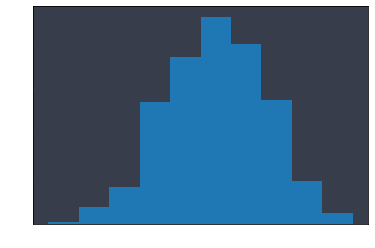

In [11]:
b = 8
plt.hist(np.random.beta(b,b, 1000))

In [ ]:
def rand_bbox(shape, lam):
    batch_size, d, h, w = shape
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(w)
    cy = np.random.randint(h)

    bbx1 = np.clip(cx - cut_w // 2, 0, w)
    bby1 = np.clip(cy - cut_h // 2, 0, h)
    bbx2 = np.clip(cx + cut_w // 2, 0, w)
    bby2 = np.clip(cy + cut_h // 2, 0, h)

    return bbx1, bby1, bbx2, bby2


def cutmix_data(x, y, beta=1., use_cuda=True):
    """CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features 
    (https://arxiv.org/pdf/1905.04899.pdf).
    """
    if beta > 0:
        lam = np.random.beta(beta, beta)
    else:
        lam = 1

    shape = x.size()
    indices = torch.randperm(shape[0])
    if use_cuda:
        indices = indices.cuda()

    bbx1, bby1, bbx2, bby2 = rand_bbox(shape, lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[indices, :, bbx1:bbx2, bby1:bby2]
    y_cut = y[indices]
    return x, y, y_cut, lam


def mixup_data(x, y, alpha=1.0, use_cuda=True):
    """mixup: Beyond Empirical Risk Minimization (https://arxiv.org/pdf/1710.09412.pdf)"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    indices = torch.randperm(x.size()[0])
    if use_cuda:
        indices = indices.cuda()

    x_mixed = lam * x + (1 - lam) * x[indices, :]
    y_mixed = y[indices]
    return x_mixed, y, y_mixed, lam


def regularized_criterion(criterion, y_pred, y, y_b, lam):
    return lam * criterion(y_pred, y) + (1 - lam) * criterion(y_pred, y_b)

In [27]:
for x, y in dl:
    break

In [28]:
print(x.shape)
y.shape

torch.Size([16, 3, 224, 224])


torch.Size([16])

In [32]:
x_mixed, y_a, y_b, lam = mixup_data(x, y, use_cuda=False)

tensor([ 3, 15,  0, 14,  7,  9,  6,  2,  4,  1, 10, 12, 11, 13,  5,  8])


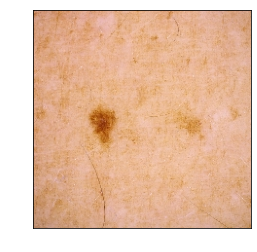

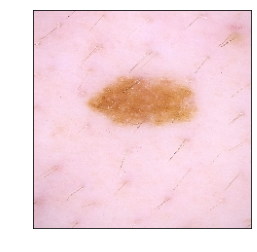

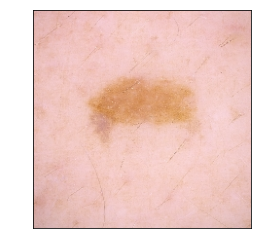

In [36]:
plt.imshow(x[1].permute(1,2,0)); plt.show()
plt.imshow(x[15].permute(1,2,0)); plt.show()
plt.imshow(x_mixed[1].permute(1,2,0))

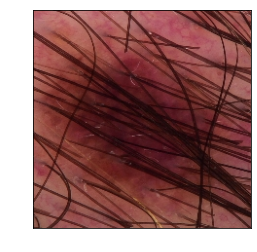

In [33]:
plt.imshow(x[3].permute(1,2,0))

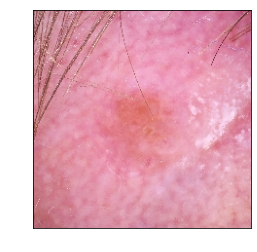

In [30]:
plt.imshow(x[0].permute(1,2,0))

In [ ]:
>>> unfold = nn.Unfold(kernel_size=(2, 3))
>>> input = torch.randn(2, 5, 3, 4)
>>> output = unfold(input)
>>> # each patch contains 30 values (2x3=6 vectors, each of 5 channels)
>>> # 4 blocks (2x3 kernels) in total in the 3x4 input
>>> output.size()
torch.Size([2, 30, 4])

>>> # Convolution is equivalent with Unfold + Matrix Multiplication + Fold (or view to output shape)
>>> inp = torch.randn(1, 3, 10, 12)
>>> w = torch.randn(2, 3, 4, 5)
>>> inp_unf = torch.nn.functional.unfold(inp, (4, 5))
>>> out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
>>> out = torch.nn.functional.fold(out_unf, (7, 8), (1, 1))
>>> # or equivalently (and avoiding a copy),
>>> # out = out_unf.view(1, 2, 7, 8)
>>> (torch.nn.functional.conv2d(inp, w) - out).abs().max()
tensor(1.9073e-06)